# Volatility surface analytics

If the implied volatility surfaces for European options is given as a function $\sigma(x,\tau)$ where $\tau=T-t$ and $x=\ln K/F$, that is twice differentiable in $x$ and once in $\tau$, then many quantities of relevance may also be comuted directly as functions $f(x,\tau)$. In this notebook we demonstrate the calculation of such quantities as:

 - Option prices and greeks (obviously!)
 - Probabilities distributions for the asset price across time horizons
 - Bounds on the shape volatility surface that are necessary and sufficient for the absence of static arbitrage
 - The integrand in the variance swap price (and so by simple numerical integration, the variance swap term structure)
 - The Dupire local volatility surface (i.e. conditional expectation of forward volatility)

The mechanism for these various calcuations involve some standard results from options theory and some occasionaly long-winded but ultimately trivial applications of differential chain rule to the Black-Scholes pricing formula. Some conveniences that we gain by going through these algebraic motions are:

 - Generality. the computations of all these quantities remain identical regardless of the specific functional form of $\sigma$, whether it be a spline, a parametric functional form such as the SABR model, or any other choice, provided the function and its derivatives are implemented. So we take any choice of volatility surface implementation: provide we can compute its derivatives also, all the related analytics come for free.
 - Encapsulation. Being specified in terms of (log) forward moneyness $x$ and relative time $\tau$, all our calcuations depend *only* upon the volatility surface in the same coordinate system. In the literature, most of these quantities are usually expressed in terms of option prices and strike prices, and so implementations are usually reliant on numerical differentiation of the output of an option pricing function. Translation into a coordinate system of implied volatility and log forward moneyness removes dependence on  model specifications such as dividends and interest rates, or upon an implementation of an options pricing model. Our implementations are all closed-form rather than numerical and therefore concise, self-contained, stable and efficient.
 - Delta-space consistency. Though not plotted in this notebook (**TODO!!**), any of these functions $f(x,\tau)$ may easily be translated in "delta-space". If we define $\Delta(x,\tau)$ as the negative of the delta of a put option for the given $x, \tau$, then for fixed $\tau$, we have that $\Delta$ is a monotonically increasing function of $x$ ranging from 0 to 1, and therefore invertible, so we can define $g(\Delta, \tau):=f(x(\Delta,\tau), t)$. This is a convenient alternative view of the "strike" dimension which effectively normalises for the tiem to expiry and the level of volatiltiy, making comparisons between different underlyings and differnt maturities more meaningful. In our chosen co-ordinate space, $\Delta_{CALL}-\Delta_{PUT}=1$ over all $(x,\tau)$, and so there is no ambiguity over "which delta" is under consideration (we have, for instance, no need for an artificial cutoff between puts on the left and calls on the right, or confusion over whether we are considering a "spot" or "forward" delta - i.e. discounted or undiscounted delta metric - issues which often give rise to complications in some implementations).

### LOTS OF CODE: SCROLL DOWN TO WHERE THE PLOTS START!!!

In [90]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

*We will use a variant of the SABR model: here's the implementation of the volatility parameterisation and its derivatives in $x$*

In [14]:
def sabr_volatility(x, fx, f1x, f2x, vol_atm, volvol, corr, compute_derivatives = True):
    ''' Calculate the volatility along with first and second derivatives wrt logstrike in the SABR model '''
    vol_atm_small = np.abs(vol_atm) < 1e-12
    u = np.where(vol_atm_small, 0.0, -fx * volvol / vol_atm)  
    x_small = np.abs(x) < 1e-5
    u_small = np.abs(u) < 1e-12
    a = np.sqrt(u**2 - 2.0 * corr * u + 1.0)
    dvdx_0 = 0.5 * volvol * corr
    d2vdx2_0 = (volvol * volvol / 3.0 - 2 * dvdx_0 * dvdx_0) / vol_atm
    v = np.where(x_small, vol_atm + dvdx_0 * x + 0.5 * d2vdx2_0 * x**2, np.where(u_small, vol_atm,
            -volvol * x / np.log((u - corr + a) / (1.0 - corr))))
    if not compute_derivatives:
        return v
    dvdx = np.where(x_small, dvdx_0 + d2vdx2_0 * x, np.where(u_small, 0.0,
            v / x * (1.0 - (f1x * v) / (vol_atm * a))))
    d2vdx2 = np.where(x_small, d2vdx2_0, np.where( u_small, 0.0,
            (dvdx - v / x) * (f2x / f1x + 2.0 * dvdx / v - (u * (u - corr) / a**2) * (f1x / fx))))
    return v, dvdx, d2vdx2

def sabr_variance(x, fx, f1x, f2x, vol_atm, volvol, corr, compute_derivatives = True):
    ''' Calculate variance (volatility squared) along with first and second eerivative wrt logstrike in SABR model '''
    tmp = sabr_volatility(x, fx, f1x, f2x, vol_atm, volvol, corr, compute_derivatives)
    if not compute_derivatives: # we only have the one result
        return tmp **2
    v, dvdx, d2vdx2 = tmp
    return v**2, 2.0 * v * dvdx, 2.0 * (dvdx * dvdx + v * d2vdx2)

def sabr_default(x):
    ''' in the case of pure stoch-vol the "local" component reduces to this '''
    return x, 1.0, 0.0

def sabr_local(x, beta):
    ''' the "local volatility'' component of SABR along with first and second derivs wrt logstrike '''
    one_minus_beta = 1 - beta
    first = np.exp(x * one_minus_beta)
    second = one_minus_beta  * first
    if beta < 1e-6:
        return np.exp(x) - 1.0, first, second
    if beta > 1 - 1e-6:
        return x, first, second
    return (first - 1) / one_minus_beta, first, second

def sabr_local_sinhtanh(x, near_wings, far_wings):
    ''' the "local volatility'' component of generalised SABR for a parameterisation with a near & far wing parameter'''
    a, b = near_wings, far_wings
    ax, bx = a*x, b*x
    sinhbx, coshbx, tanhax = np.sinh(bx), np.cosh(bx), np.tanh(ax)
    tanhax2 = tanhax**2
    f0 = sinhbx - bx + tanhax/a
    f1 = (coshbx - 1.0) * b + 1.0 -tanhax2
    f2 = sinhbx * b**2 - 2.0 * a * tanhax * (1.0 - tanhax2)
    return f0, f1, f2    

*Here's a volatility surface class that takes a vol curve at specified expiries, e.g. the SABR-like ones specified above, and (a) interpolates in the time direction to give a complete surface, and (b) provides all the implementation of the various quantities that we care about*

In [15]:
import datetime
import math
from abc import abstractmethod
from bisect import bisect_right
from collections import OrderedDict
from scipy.optimize import brentq
from scipy.stats import norm

def _xrange_for_volatility(volatility, time_to_expiry, x_min=None, x_max=None):
    ''' Return the integration range given a level of volatility and an as_of time.
        Dynamically determine a range for x (x = ln(K/F)), we want to span the interesting parameter space (i.e.
        delta between -1 to 1).
    '''
    if x_min is None or x_max is None:
        # Adjust min and max x by vol and sqrt(t) and a fudge factor
        adjustment = volatility * math.sqrt(time_to_expiry) * 5
    x_min = adjustment * (norm.ppf(0.001) - adjustment / 2) if x_min is None else x_min
    x_max = adjustment * (norm.ppf(0.999) - adjustment / 2) if x_max is None else x_max
    return float(x_min), float(x_max)

class SimpleCalendar(object):
    ''' A simple version of the business time calendar function corresponding trivially to act/365 daycount
    (more generally we might consider a calendar with weekend weighting & holiday weighting or event knowledge)
    '''
    def time_interval(self, start, end):
        return (end-start).total_seconds() / 60. /60. /24. / 365.
    
class VolatilitySurface(object):
    ''' Volatility surface class, computes implied volatility for a given strike/expiry '''

    def __init__(self, as_of, expiry_to_vol_curve, calendar):
        self.as_of = as_of
        self._expiry_to_vol_curve = expiry_to_vol_curve # list of (expiration_time, vol_curve) tuples
        self.expiry_to_vol_curve = OrderedDict(expiry_to_vol_curve)
        self._calendar = calendar # funciton for computing the business time interval between any dates

    def pillar_dates(self):
        ''' Dates at which the volatiilty skew curves are defined '''
        return list(zip(*self._expiry_to_vol_curve))[0]

    @staticmethod
    def _calc_vol(variance):
        ''' volatility '''
        return np.sqrt(variance)

    @staticmethod
    def _calc_vol_skew(volatility, variance_skew):
        ''' volatility skew '''
        return 0.5 * variance_skew / volatility

    @staticmethod
    def _calc_vol_smile(volatility, volatility_skew, variance_smile):
        ''' volatility smile '''
        return (0.5 * variance_smile - volatility_skew * volatility_skew) / volatility

    @staticmethod
    def _calc_vol_decay(volatility, varDecay):
        ''' volatility decay '''
        return VolatilitySurface._calc_vol_skew(volatility, varDecay)  # same calculation; just chain rule...

    @staticmethod
    def _calc_skew_lbound(strike, sqrt_time_to_expiry, volatility):
        ''' lower arbitrage bound on the skew (first derivative)'''
        volatility *= sqrt_time_to_expiry
        black_scholes_d2 = -strike / volatility + volatility / 2.0
        ret = -norm.cdf(-black_scholes_d2) / (norm.pdf(black_scholes_d2))
        # we may have nans where black_scholes_d2 has large magnitude and we have divided by zero
        # in this case the limits are -inf and 0, depending on which side we are on
        ret[np.isnan(ret)] = np.where(black_scholes_d2 < 0.0, -np.inf, 0.0)[np.isnan(ret)]
        ret /= sqrt_time_to_expiry
        return ret

    @staticmethod
    def _calc_skew_ubound(strike, sqrt_time_to_expiry, volatility):
        ''' upper arbitrage bound on the skew (first derivative) '''
        volatility *= sqrt_time_to_expiry
        black_scholes_d2 = -strike / volatility + volatility / 2.0
        ret = norm.cdf(black_scholes_d2) / (norm.pdf(black_scholes_d2))

        # we may have nans where black_scholes_d2 has large magnitude and we have divided by zero
        # in this case the limits are inf and 0, depending on which side we are on
        ret[np.isnan(ret)] = np.where(black_scholes_d2 > 0.0, np.inf, 0.0)[np.isnan(ret)]

        ret /= sqrt_time_to_expiry
        return ret

    @staticmethod
    def _calc_smile_lbound(strike, sqrt_time_to_expiry, volatility, volatility_skew):
        ''' lower arbitrage bound on the smile (second derivative)'''
        volatility *= sqrt_time_to_expiry
        volatility_skew *= sqrt_time_to_expiry
        black_scholes_d2 = -strike / volatility + volatility / 2.0
        black_scholes_d1 = black_scholes_d2 + volatility

        # reuse the variables (note they're not really d1 d2 any more)
        black_scholes_d1 *= volatility_skew
        black_scholes_d2 *= volatility_skew

        return -(1.0 + black_scholes_d1 + black_scholes_d2 + black_scholes_d1 * black_scholes_d2) / volatility

    @staticmethod
    def _calc_distribution(strike, sqrt_time_to_expiry, volatility, volatility_skew):
        ''' distribution '''
        volatility *= sqrt_time_to_expiry
        volatility_skew *= sqrt_time_to_expiry
        black_scholes_d2 = -strike / volatility - volatility / 2.0
        return norm.cdf(-black_scholes_d2) + norm.pdf(black_scholes_d2) * volatility_skew

    @staticmethod
    def _calc_distribution_complement(strike, sqrt_time_to_expiry, volatility, volatility_skew):
        ''' distribution complement '''
        volatility *= sqrt_time_to_expiry
        volatility_skew *= sqrt_time_to_expiry
        black_scholes_d2 = -strike / volatility - volatility / 2.0
        return norm.cdf(black_scholes_d2) - norm.pdf(black_scholes_d2) * volatility_skew

    @staticmethod
    def _calc_density(strike, sqrt_time_to_expiry, volatility, volatility_skew, volatility_smile):
        ''' density '''
        volatility *= sqrt_time_to_expiry
        volatility_skew *= sqrt_time_to_expiry
        volatility_smile *= sqrt_time_to_expiry
        black_scholes_d2 = -strike / volatility - volatility / 2.0
        black_scholes_d1 = black_scholes_d2 + volatility
        return (norm.pdf(black_scholes_d2) * ((1.0 + black_scholes_d1 * volatility_skew) *
            (1.0 + black_scholes_d2 * volatility_skew) / volatility + volatility_smile))

    @staticmethod
    def _calc_call_price(strike, sqrt_time_to_expiry, volatility):
        ''' undiscounted european call price of standardised option with unit forward '''
        volatility *= sqrt_time_to_expiry
        black_scholes_d2 = -strike / volatility - volatility / 2.0
        black_scholes_d1 = black_scholes_d2 + volatility
        return norm.cdf(black_scholes_d1) - np.exp(strike) * norm.cdf(black_scholes_d2)

    @staticmethod
    def _calc_put_price(strike, sqrt_time_to_expiry, volatility):
        ''' undiscounted european put price of standardised option with unit forward '''
        volatility *= sqrt_time_to_expiry
        black_scholes_d2 = -strike / volatility - volatility / 2.0
        black_scholes_d1 = black_scholes_d2 + volatility
        return np.exp(strike) * norm.cdf(-black_scholes_d2) - norm.cdf(-black_scholes_d1)

    @staticmethod
    def _calc_call_delta(strike, sqrt_time_to_expiry, volatility):
        ''' undiscounted delta of standardised european call option with unit forward '''
        volatility *= sqrt_time_to_expiry
        black_scholes_d1 = -strike / volatility + volatility / 2.0
        return norm.cdf(black_scholes_d1)

    @staticmethod
    def _calc_put_delta(strike, sqrt_time_to_expiry, volatility):
        ''' calculate undiscounted delta of standardised european put option with unit forward '''
        volatility *= sqrt_time_to_expiry
        black_scholes_d1 = -strike / volatility + volatility / 2.0
        return -norm.cdf(-black_scholes_d1)

    @staticmethod
    def _calc_local_variance(strike, sqrt_time_to_expiry, volatility, volatility_skew, volatility_smile, variance_decay):
        ''' calculate dupire local variance '''
        # TODO : we refactored the local variance into a formulation in terms of variance...
        # can we do this elsewhere to result in no need to compute sqrt_time_to_expiry?
        volatility_decay = (variance_decay * sqrt_time_to_expiry *
            sqrt_time_to_expiry + volatility * volatility)  # total variance decay

        volatility_smile /= volatility
        volatility_skew /= volatility
        volatility *= sqrt_time_to_expiry
        volatility *= volatility
        black_scholes_d2 = -strike - volatility / 2.0
        black_scholes_d1 = black_scholes_d2 + volatility

        return (volatility_decay / (0.5 * ((1.0 + black_scholes_d1 * volatility_skew) *
            (1.0 + black_scholes_d2 * volatility_skew) / volatility + volatility_smile)))

    @staticmethod
    def _calc_local_volatility(local_variance):
        ''' calculate dupire local volatility '''
        return sqrt(local_variance)

    @staticmethod
    def _calculate_curve(curve, strikes):
        ''' calculate the variance and its first and second derivatives wrt logstrike on a given curve '''
        variance = None
        variance_skew = None
        variance_smile = None

        variance = curve.y_values(strikes)
        variance_skew = curve.dydx_values(strikes)
        variance_smile = curve.d2ydx2_values(strikes)

        return (variance, variance_skew, variance_smile)

    def _calculate_core(self, expiries, strikes):
        ''' The core calculations for a volatility surface are the variance, the first and second derivatives
            in the strike dimension, and the first derivative in the time dimension. this function does those
            computations, by interpolating appropriately between two curves. All other quantities relating to the
            volatility surface (local volatility, distribution etc) can be computed from the results of this
            function without any need for understanding of the specific functional form of the surface
        '''
        
        lo_variance = None
        hi_variance = None
        lo_skew = None
        hi_skew = None
        lo_smile = None
        hi_smile = None

        m_rows = len(expiries)
        n_cols = len(strikes)

        return_variance = np.empty((m_rows, n_cols))
        return_skew = np.empty((m_rows, n_cols))
        return_smile = np.empty((m_rows, n_cols))
        return_decay = np.empty((m_rows, n_cols))

        pillar_expiries = sorted(self.expiry_to_vol_curve)

        time_intervals = [
            self._calendar.time_interval(self.as_of, pillar_expiry)
            for pillar_expiry in pillar_expiries]

        k_index = bisect_right(pillar_expiries, expiries[0])

        i_index = 0
        for t_expiry in expiries:
            while k_index < len(pillar_expiries) and pillar_expiries[k_index] <= t_expiry:
                k_index += 1
                lo_variance = hi_variance
                lo_skew = hi_skew
                lo_smile = hi_smile
                hi_variance = None
                hi_skew = None
                hi_smile = None

            # we used to only allow compuation for expiry dates up to the last pillar date of the surface
            # in which case we would have the additional constraint " and pillar_expiries[-1] == t_expiry"
            # in the following "if". But being more lenient, always doing -=1 if we are off the end results
            # in flat extrapolation off the end of the surface. We should revisit & do a more sophisticate extrap
            # regime in due course.
            if len(pillar_expiries) == k_index:
                k_index -= 1

            if lo_variance is None:
                lo_variance, lo_skew, lo_smile = self._calculate_curve(
                    self.expiry_to_vol_curve[pillar_expiries[k_index - 1]], strikes)
            if hi_variance is None:
                hi_variance, hi_skew, hi_smile = self._calculate_curve(
                    self.expiry_to_vol_curve[pillar_expiries[k_index]], strikes)

            # i'd quite like to abstract out the interpolation regime...would like to use cubic or
            # other, not just linear as below

            if len(time_intervals) == 1:
                interval_dt = 0.0
                theta = 0.0
            else:
                interval_dt = time_intervals[k_index] - time_intervals[k_index - 1]
                theta = self._calendar.time_interval(pillar_expiries[k_index - 1], t_expiry) / interval_dt

            theta1m = 1.0 - theta

            return_variance[i_index, :] = theta1m * lo_variance + theta * hi_variance
            return_skew[i_index, :] = theta1m * lo_skew + theta * hi_skew
            return_smile[i_index, :] = theta1m * lo_smile + theta * hi_smile
            if interval_dt == 0.0:
                return_decay[i_index, :] = np.zeros(len(hi_variance))
            else:
                return_decay[i_index, :] = (hi_variance - lo_variance) / interval_dt
            i_index += 1

        return (return_variance, return_skew, return_smile, return_decay)

    def variance(self,  expiries, strikes):
        ''' compute variance '''
        variance, _, _, _ = self._calculate_core(expiries, strikes)
        return variance

    def variance_skew(self, expiries, strikes):
        ''' compute variance_skew '''
        _, variance_skew, _, _ = self._calculate_core(expiries, strikes)
        return variance_skew

    def variance_smile(self, expiries, strikes):
        ''' compute variance_smile '''
        _, _, variance_smile, _ = self._calculate_core(expiries, strikes)
        return variance_smile

    def variance_decay(self, expiries, strikes):
        ''' compute variance_decay '''
        _, _, _, var_decay = self._calculate_core(expiries, strikes)
        return var_decay

    def volatility(self, expiries, strikes):
        ''' compute volatility '''
        variance = self.variance(expiries, strikes)
        return np.sqrt(variance)

    def volatility_skew(self, expiries, strikes):
        ''' compute volatility_skew '''
        variance, variance_skew, _, _ = self._calculate_core(expiries, strikes)
        volatility = np.sqrt(variance)
        return self._calc_vol_skew(volatility, variance_skew)

    def volatility_smile(self, expiries, strikes):
        ''' compute volatility_smile '''
        variance, variance_skew, variance_smile, _ = self._calculate_core(expiries, strikes)
        volatility = np.sqrt(variance)
        volatility_skew = self._calc_vol_skew(volatility, variance_skew)
        return self._calc_vol_smile(volatility, volatility_skew, variance_smile)

    def volatility_decay(self, expiries, strikes):
        ''' compute volatility_decay '''
        variance, _, _, var_decay = self._calculate_core(expiries, strikes)
        volatility = np.sqrt(variance)
        return self._calc_vol_decay(volatility, var_decay)

    def distribution(self, expiries, strikes):
        ''' compute distribution '''
        variance, variance_skew, _, _ = self._calculate_core(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        volatility_skew = self._calc_vol_skew(volatility, variance_skew)
        return self._calc_distribution(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility,
            volatility_skew)

    def distribution_complement(self, expiries, strikes):
        ''' compute distribution_complement '''
        variance, variance_skew, _, _ = self._calculate_core(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        volatility_skew = self._calc_vol_skew(volatility, variance_skew)
        return self._calc_distribution_complement(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility,
            volatility_skew)

    def density(self, expiries, strikes):
        ''' compute density '''
        variance, variance_skew, variance_smile, _ = self._calculate_core(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        volatility_skew = self._calc_vol_skew(volatility, variance_skew)
        volatility_smile = self._calc_vol_smile(volatility, volatility_skew, variance_smile)
        return self._calc_density(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility,
            volatility_skew,
            volatility_smile)

    def call_price(self, expiries, strikes):
        ''' calculate undiscounted european call price of standardised option with unit forward '''
        variance = self.variance(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        return self._calc_call_price(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility)

    def put_price(self, expiries, strikes):
        ''' calculate undiscounted european put price of standardised option with unit forward '''
        variance = self.variance(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        return self._calc_put_price(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility)

    def call_delta(self, expiries, strikes):
        ''' calculate undiscounted european call delta of standardised option with unit forward '''
        variance = self.variance(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        return self._calc_call_delta(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility)

    def put_delta(self, expiries, strikes):
        ''' calculate undiscounted european put delta of standardised option with unit forward '''
        variance = self.variance(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        return self._calc_put_delta(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility)

    def logstrike_from_call_delta(self, expiries, deltas):
        ''' inversion of the (undiscounted) call delta function with respect to strike '''
        ret = np.zeros((len(expiries), len(deltas)))
        for i in range(len(expiries)):
            for j in range(len(deltas)):
                ret[i, j] = brentq(lambda x: self.call_delta(
                    np.array([expiries[i]]), np.array([x])).flatten() - np.array([deltas[j]]),
                    -10.0,
                    10.0)
        return ret

    def logstrike_from_put_delta(self, expiries, deltas):
        ''' inversion of the (undiscounted) put delta function with respect to strike '''
        ret = np.zeros((len(expiries), len(deltas)))
        for i in range(len(expiries)):
            for j in range(len(deltas)):
                ret[i, j] = brentq(lambda x: self.put_delta(
                    np.array([expiries[i]]), np.array([x])).flatten() - np.array([deltas[j]]),
                    -10.0,
                    10.0)
        return ret

    def volatility_skew_lbound(self, expiries, strikes):
        ''' compute volatility_skew_lbound '''
        variance = self.variance(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        return self._calc_skew_lbound(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility)

    def volatility_skew_ubound(self, expiries, strikes):
        ''' compute volatility_skew_ubound '''
        variance = self.variance(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        return self._calc_skew_ubound(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility)

    def volatility_smile_lbound(self, expiries, strikes):
        ''' compute volatility_smile_lbound '''
        variance, variance_skew, _, _ = self._calculate_core(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        volatility_skew = self._calc_vol_skew(volatility, variance_skew)
        return self._calc_smile_lbound(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility,
            volatility_skew)

    def local_variance(self, expiries, strikes):
        ''' compute local_variance '''
        variance, variance_skew, variance_smile, var_decay = self._calculate_core(expiries, strikes)
        sqrt_time_to_expiry = np.sqrt(
            [self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        volatility = np.sqrt(variance)
        volatility_skew = self._calc_vol_skew(volatility, variance_skew)
        volatility_smile = self._calc_vol_smile(volatility, volatility_skew, variance_smile)
        return self._calc_local_variance(
            strikes.reshape((1, len(strikes))),
            sqrt_time_to_expiry.reshape((len(sqrt_time_to_expiry), 1)),
            volatility,
            volatility_skew,
            volatility_smile,
            var_decay)

    def local_volatility(self, expiries, strikes):
        ''' compute local_volatility '''
        return np.sqrt(self.local_variance(expiries, strikes))

    def variance_integrand(self, expiries, strikes):
        ''' Compute the integrand for the implied variance calculation. '''
        vols = self.volatility(expiries, strikes)
        times_to_expiry = np.array([self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])
        y = vols * np.sqrt(times_to_expiry)[:, np.newaxis]
        d1_value = -strikes / y + y / 2.0
        d2_value = d1_value - y
        puts = strikes < 0
        calls = ~puts
        return np.hstack([
                    norm.cdf(-d2_value[:, puts]) - np.exp(-strikes[puts]) * norm.cdf(-d1_value[:, puts]),
                    np.exp(-strikes[calls]) * norm.cdf(d1_value[:, calls]) - norm.cdf(d2_value[:, calls])
                    ])

    def implied_variance(self, expiries, x_min=None, x_max=None, number_of_points=1000):
        ''' Compute the implied variance. '''
        if any(expiries < self.as_of):
            raise ValueError("One or more expiries are before this surface's as_of time of {}".format(self.as_of))

        times_to_expiry = np.array([self._calendar.time_interval(self.as_of, expiry) for expiry in expiries])

        if x_min is not None and x_max is not None:
            # Constant integration range across all expiries
            x_range = np.linspace(x_min, x_max, number_of_points)
            integral = np.trapz(self.variance_integrand(expiries, x_range), x_range)
        else:
            # Different integration range per expiry
            def implied_variance_worker(expiry, time_to_expiry, x_min, x_max):
                # Construct an evaluation range for this expiry, get the integrand and evaluate it.
                reference_vol = self.volatility(np.array([expiry]), np.array([0]))
                x_min, x_max = _xrange_for_volatility(reference_vol, time_to_expiry, x_min=x_min, x_max=x_max)
                x_range = np.linspace(x_min, x_max, number_of_points)
                return np.trapz(self.variance_integrand(np.array([expiry]), x_range), x_range)
            integral = np.vectorize(implied_variance_worker)(expiries, times_to_expiry, x_min, x_max)

        return 2.0 / times_to_expiry * integral

    def forward_implied_variance(self, datetime_1, datetime_2):
        ''' Compute the implied forward variance between the two provided datetimes.
            The forward implied variance is calculated as
                forward implied variance = 1 / tau2 * (tau * implied_variance_to_tau - tau1 *  implied_variance_to_tau1)
            where
                tau is the time from now to datetime_2
                tau1 is the time from now to datetime_1
                tau2 is the time from datetime_1 to datetime_2.
        '''
        assert self.as_of <= datetime_1
        assert datetime_1 < datetime_2
        tau = self._calendar.time_interval(self.as_of, datetime_2)
        tau1 = self._calendar.time_interval(self.as_of, datetime_1)
        tau2 = self._calendar.time_interval(datetime_1, datetime_2)
        implied_variance_to_tau1, implied_variance_to_tau = self.implied_variance(
            np.array([datetime_1, datetime_2]))
        return 1.0 / tau2 * (tau * implied_variance_to_tau - tau1 * implied_variance_to_tau1)

class ModifiedSabrVolatilityCurve(object):
    ''' Generalised short-limit SABR parameterisation
        with 2-parameter "local-overlay" function in terms of sinh and tanh
    '''
    def __init__(self, atm_vol, vol_vol, corr, near_wings, far_wings):
        self._atm_vol = atm_vol
        self._vol_vol = vol_vol
        self._corr = corr
        self._near_wings = near_wings
        self._far_wings = far_wings

    # variance and its derivatives, as required by volatility surface

    def y_values(self, x):
        ''' level of variance for given logstrikes in the SABR model with general form '''
        f, _, _ = sabr_local_sinhtanh(x, self._near_wings, self._far_wings)
        return sabr_variance(x, f, _, _, self._atm_vol, self._vol_vol, self._corr, compute_derivatives = False)

    def dydx_values(self, x):
        ''' first derivative of the level of variance for given logstrikes  in the SABR model with general form '''
        f0, f1, f2 = sabr_local_sinhtanh(x, self._near_wings, self._far_wings)
        _, var_skew, _ = sabr_variance(x, f0, f1, f2, self._atm_vol, self._vol_vol, self._corr, compute_derivatives = True)
        return var_skew

    def d2ydx2_values(self, x):
        ''' second derivative of the level of variance for given logstrikes  in the SABR model with general form '''
        f0, f1, f2 = sabr_local_sinhtanh(x, self._near_wings, self._far_wings)
        _, _, var_smile = sabr_variance(x, f0, f1, f2, self._atm_vol, self._vol_vol, self._corr, compute_derivatives = True)
        return var_smile

*Here we construct an instance of our volatility surface (with made up parameters, something that looks vaguely reasonable)*

In [12]:
params = pd.DataFrame(
    {
        datetime.datetime(2018,1,1) :  [0.10,  1.0,  -0.7,  1.,  1.],
        datetime.datetime(2018,1,7) :  [0.11,  0.9,  -0.6,  1.,  1.],
        datetime.datetime(2018,1,14) : [0.12,  0.8,  -0.5,  1.,  1.],
        datetime.datetime(2018,2,1) :  [0.13,  0.7,  -0.4,  1.,  1.],
        datetime.datetime(2018,3,1) :  [0.14,  0.6,  -0.3,  1.,  1.],
        datetime.datetime(2018,7,1) :  [0.15,  0.5,  -0.2,  1.,  1.],
        datetime.datetime(2018,10,1) : [0.16,  0.4,  -0.1,  1.,  1.],
        datetime.datetime(2019,1,1) :  [0.17,  0.3,  -0.0,  1.,  1.],
        datetime.datetime(2020,1,1) :  [0.16,  0.2,  -0.0,  1.,  1.]
    },
    index = ["volatm", "volvol", "corr", "nearwing", "farwing"]
)

surface = VolatilitySurface(params.columns[0], [(p, ModifiedSabrVolatilityCurve(*params[p])) for p in params] , SimpleCalendar())
params.transpose()

,volatm,volvol,corr,nearwing,farwing
2018-01-01,0.10,1.0,-0.7,1.0,1.0
2018-01-07,0.11,0.9,-0.6,1.0,1.0
2018-01-14,0.12,0.8,-0.5,1.0,1.0
2018-02-01,0.13,0.7,-0.4,1.0,1.0
2018-03-01,0.14,0.6,-0.3,1.0,1.0
2018-07-01,0.15,0.5,-0.2,1.0,1.0
2018-10-01,0.16,0.4,-0.1,1.0,1.0
2019-01-01,0.17,0.3,-0.0,1.0,1.0
2020-01-01,0.16,0.2,-0.0,1.0,1.0


*Computation: let's call each of the functions that we want to look at, over the same range of log-moneyness and expiry time*

In [82]:
import warnings
warnings.filterwarnings("ignore")

x = np.linspace(-0.5,0.5,501)
t = surface.pillar_dates()
t2 = pd.date_range(start = t[0], end = t[-1], freq = "W")
v2 = surface.volatility(t2, x)

functions = [
    'call_delta','call_price','put_delta','put_price',
    'density','distribution','distribution_complement',
    'local_volatility','variance_integrand', 
    'volatility','volatility_decay','volatility_skew','volatility_smile',
    'volatility_skew_lbound','volatility_skew_ubound','volatility_smile_lbound']

results = {f: getattr(surface,f)(t,x) for f in functions}
results2 = {f: getattr(surface,f)(t2,x) for f in functions}

# The volatility surface and its derivatives

Below are shown the volatility surface $\sigma(x,\tau)$, ranging over $x$ for various values of $\tau$, and its derivatives $\frac{\partial \sigma}{\partial x}$, $\frac{\partial^2 \sigma}{\partial x^2}$, $\frac{\partial \sigma}{\partial \tau}$ (which in our implementation we refer to as "skew", "smile" and "decay" respectively - terminology which is not necessarily standard). All subsequent plots in this notebook are straightforward functions of these quantities.

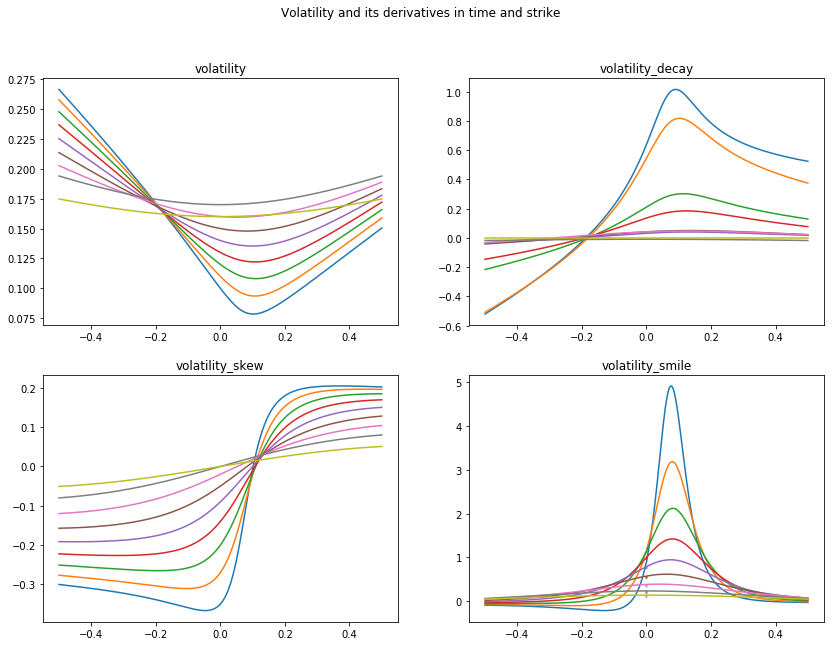

In [83]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
for a, f in zip(ax.flatten(), ['volatility','volatility_decay','volatility_skew','volatility_smile']):
    fig.suptitle("Volatility and its derivatives in time and strike")
    a.set_title(f)
    for i in range(len(t)):
         a.plot(x,results[f][i,:].flatten())          


# Option prices and greeks

In our coordinate system, the undiscounted price of a European call option with unit forward price is $c(x,\tau)=N(-x/y+y/2)-e^xN(-x/y-y/2)$ where $y=\sigma(x,\tau)\sqrt{\tau}$. If we always work with undiscounted option prices, the value of puts, and all the option greeks, are similarly functions of $x,\tau$. Calls, puts, and their deltas are shown below.

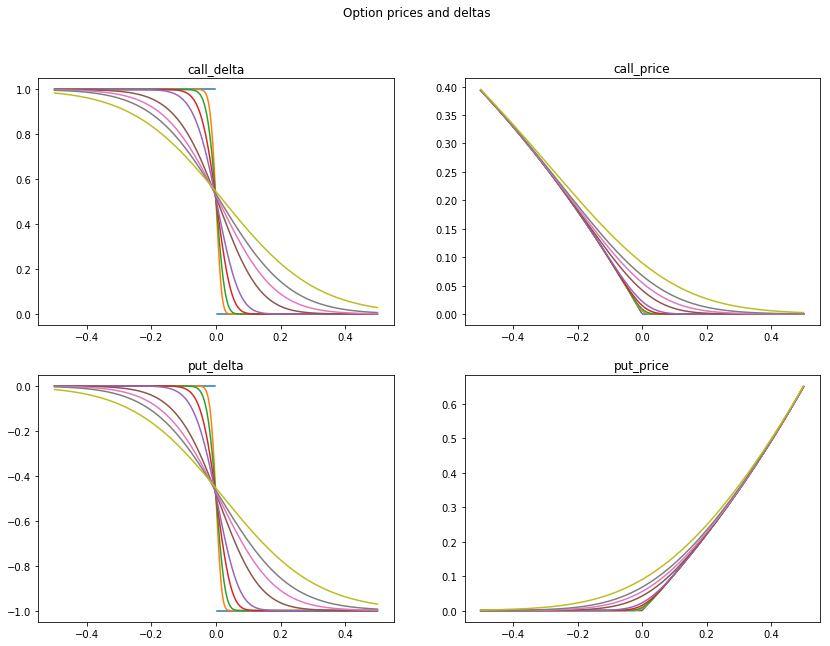

In [84]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
for a, f in zip(ax.flatten(), ['call_delta','call_price','put_delta','put_price']):
    fig.suptitle("Option prices and deltas")
    a.set_title(f)
    for i in range(len(t)):
         a.plot(x,results[f][i,:].flatten())

# Probability densities

The result of Breeden and Litzenberger shows that the derivative of option prices with respect to strike results in the (risk-neutral implied) probability distribution of the underlying asset, for each $\tau$. Applying chain rule to formulate the derivative of option prices with respect to strike, in terms of the derivatives of the implied volatility skew with respect to log-moneyness, gives us the following plots.

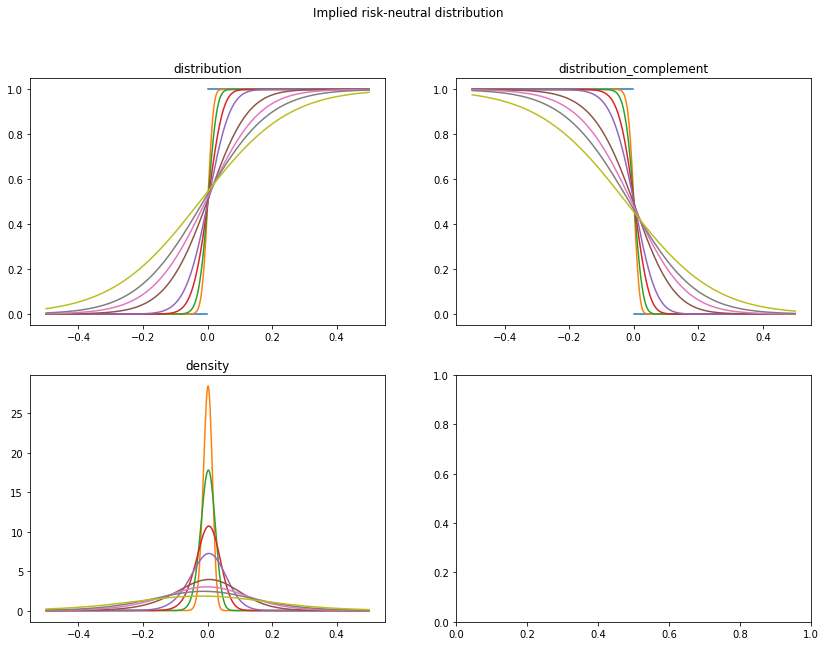

In [85]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
for a, f in zip(ax.flatten(), ['distribution','distribution_complement','density']):
    fig.suptitle("Implied risk-neutral distribution")
    a.set_title(f)
    for i in range(len(t)):
         a.plot(x,results[f][i,:].flatten())      

# Dupire local volatility

In a similar vein to the density function, the Dupire local volatility (*which can be thought of either as a particular model for the asset price volatility that consistently recovers the volatiltiy smile, or as the expectation of volatility in the unknown model conditional on the asset price, by application of Gyongy's theroem*) may also be translated into a function of $x,\tau$ and is therefore easily computed:

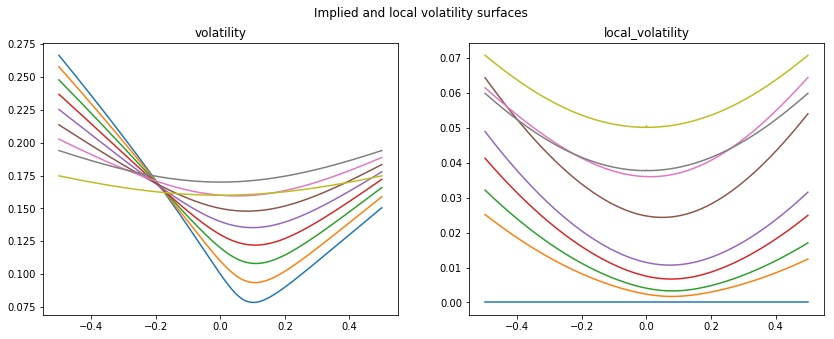

In [86]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
for a, f in zip(ax.flatten(), ['volatility','local_volatility']):
    fig.suptitle("Implied and local volatility surfaces")
    a.set_title(f)
    for i in range(len(t)):
         a.plot(x,results[f][i,:].flatten())    

# Arbitrage bounds

A paper of Carr and Madan demonstrates that necessary and sufficient conditions for a lack of arbitrage  in the option surface is that verical spreads, butterfly spreads, and calendar spreads, all having non-negative payoffs, must have on-negative prices. Thes conditions can be translated into constraints on the density/distribution functions plotted previously, and therefore can be expressed in terms of constraints on the slope and convexity of the volatiltiy surface. The constraint of positively priced vertical spreads, for calls and puts repsectively, can be shown to be equivalent to an upper and lower bound on $\frac{\partial \sigma}{\partial x}$. Positively priced butterfly spreads equate to a lower bound on $\frac{\partial^2 \sigma}{\partial x^2}$. The condition on calendar spreads constrains $\frac{\partial \sigma}{\partial \tau}$. We can see below that our example surface satisfies the necessary constraints.

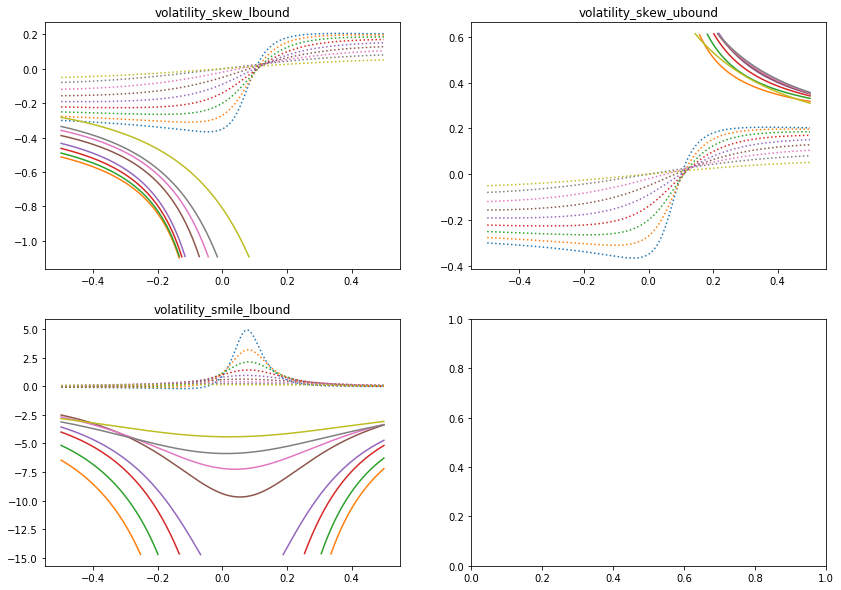

In [87]:
fig, ax = plt.subplots(2,2, figsize=(14,10))

a = ax[0,0]
a.set_title('volatility_skew_lbound')
for i in range(len(t)):
     a.plot(x,np.where(
         results['volatility_skew_lbound'][i,:].flatten() > 3 * np.min(results['volatility_skew']),
         results['volatility_skew_lbound'][i,:].flatten(),
         np.nan), color = "C{}".format(i))
     a.plot(x, results['volatility_skew'][i,:].flatten(), color = "C{}".format(i), linestyle = ":")

a = ax[0,1]
a.set_title('volatility_skew_ubound')
for i in range(len(t)):
     a.plot(x,np.where(
         results['volatility_skew_ubound'][i,:].flatten() < 3 * np.max(results['volatility_skew']),
         results['volatility_skew_ubound'][i,:].flatten(),
         np.nan), color = "C{}".format(i))
     a.plot(x, results['volatility_skew'][i,:].flatten(), color = "C{}".format(i), linestyle = ":")
    
a = ax[1,0]
a.set_title('volatility_smile_lbound')
for i in range(len(t)):
     a.plot(x,np.where(
         results['volatility_smile_lbound'][i,:].flatten() > 3 * -np.max(results['volatility_smile']),
         results['volatility_smile_lbound'][i,:].flatten(),
         np.nan), color = "C{}".format(i))
     a.plot(x, results['volatility_smile'][i,:].flatten(), color = "C{}".format(i), linestyle = ":")

# for a, f in zip(ax.flatten(), ['volatility_skew_lbound','volatility_skew_ubound','volatility_smile_lbound']):
#     fig.suptitle("Arbitrage bounds")
#     a.set_title(f)
#     for i in range(len(t)):
#          a.plot(x,results[f][i,:].flatten())    

# Variance swap level

The "implied variance", aka the theoretically fair strike for a variance swap, can be computed as a weighted integral over option prices, or equivalently, as a weighted average over the implied volatility curve for fixed maturity. This can also therefore be plotted directlly from our volatilty surface. The weighted volatilty, i.e. the integrand, is a function of $x,\tau$ like everything else that we have considered here. The integration is performed numerically (a simple trapezoid integration).

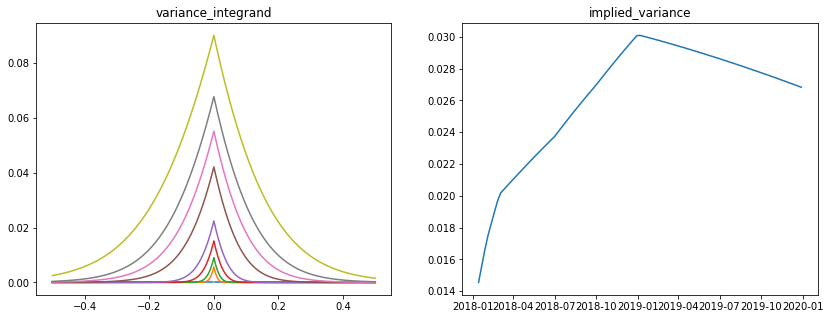

In [120]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

a = ax[0]
a.set_title('variance_integrand')
for i in range(len(t)):
     a.plot(x, results['variance_integrand'][i,:].flatten(), color = "C{}".format(i))

time_axis = np.array(pd.date_range(surface.as_of, t[-1], freq="W"))[1:]
variance = surface.implied_variance(np.array([pd.Timestamp(tval) for tval in time_axis]))
ax[1].set_title('implied_variance')
ax[1].plot(time_axis, variance);